In [18]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import pickle

# --- GrokNet Model (Unchanged) ---
class GrokNet(nn.Module):
    def __init__(self, N, M):
        super(GrokNet, self).__init__()
        self.N_val = torch.tensor(N, dtype=torch.float32)
        self.M_val = torch.tensor(M, dtype=torch.float32)
        self.W1 = nn.Parameter(torch.randn(2*N, M))
        self.W2 = nn.Parameter(torch.randn(M, N))

    def forward(self, x):
        z = torch.square(x @ self.W1 / torch.sqrt(self.M_val))
        y = (z @ self.W2) / self.N_val
        return y

    def hidden(self, x):
        with torch.no_grad():
            return torch.square(x @ self.W1 / torch.sqrt(self.M_val))

# --- Data Generation for GrokNet (Unchanged) ---
def division_mod_p_data_groknet(p):
    full_set = (np.arange(p).reshape(-1,1) + np.arange(p).reshape(1,-1)) % p
    pairs_and_sums = np.array([(x1, x2, full_set[x1, x2]) for x1 in range(p) for x2 in range(p)])
    return torch.from_numpy(pairs_and_sums).long()

# --- CORRECTED: Adam Direction Function ---
def compute_next_adam_direction(optimizer, epsilon=1e-8):
    """
    Computes the flattened Adam update direction for the UPCOMING step.
    """
    beta1, beta2 = optimizer.param_groups[0]['betas']
    direction_parts = []
    for p in optimizer.param_groups[0]['params']:
        if p.grad is None:
            continue
        grad = p.grad
        state = optimizer.state[p]
        # State initialization
        if len(state) == 0:
            # FIX: Initialize step as a tensor on the correct device
            state['step'] = torch.tensor(0.0, device=p.device)
            state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
            state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

        exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']

        # The step for the upcoming update is now a tensor
        step_t = state['step'] + 1

        # Manually calculate the next m_t and v_t
        exp_avg_next = beta1 * exp_avg + (1 - beta1) * grad
        exp_avg_sq_next = beta2 * exp_avg_sq + (1 - beta2) * (grad * grad)

        # Bias correction using tensor arithmetic
        bias_correction1 = 1 - beta1 ** step_t
        bias_correction2 = 1 - beta2 ** step_t

        m_hat = exp_avg_next / bias_correction1
        v_hat = exp_avg_sq_next / bias_correction2
        
        direction_parts.append((m_hat / (torch.sqrt(v_hat) + epsilon)).view(-1))

    if not direction_parts:
        if optimizer.param_groups[0]['params']:
            return torch.tensor([], device=optimizer.param_groups[0]['params'][0].device)
        else:
            return torch.tensor([])
    return torch.cat(direction_parts)


# --- Fisher-Vector Product Function (Unchanged from last fix) ---
def fisher_vector_product(model, input_batch, target_batch, vector):
    logits = model(input_batch)
    loss = F.mse_loss(logits, target_batch, reduction='sum')
    first_grads = torch.autograd.grad(loss, model.parameters(), create_graph=True, allow_unused=True)
    flat_first_grads = torch.cat([g.view(-1) for g in first_grads if g is not None])
    if vector.size(0) < flat_first_grads.size(0):
        padding = torch.zeros(flat_first_grads.size(0) - vector.size(0), device=vector.device)
        vector = torch.cat([vector, padding])
    elif vector.size(0) > flat_first_grads.size(0):
        vector = vector[:flat_first_grads.size(0)]
    grad_dot_vector = (flat_first_grads * vector).sum()
    fisher_v_product = torch.autograd.grad(grad_dot_vector, model.parameters(), retain_graph=True, allow_unused=True)
    return torch.cat([g.view(-1) for g in fisher_v_product if g is not None])


# --- Conjugate Gradient (Unchanged) ---
def conjugate_gradient(A_fn, b, max_iter=10, tol=1e-6):
    x = torch.zeros_like(b)
    r = b - A_fn(x)
    p = r
    rs_old = torch.dot(r, r)
    for i in range(max_iter):
        Ap = A_fn(p)
        alpha = rs_old / (torch.dot(p, Ap) + 1e-12)
        x = x + alpha * p
        r = r - alpha * Ap
        rs_new = torch.dot(r, r)
        if rs_new.sqrt() < tol:
            break
        p = r + (rs_new / rs_old) * p
        rs_old = rs_new
    return x

# --- Cosine Similarity (Unchanged from last fix) ---
def compute_cosine_similarity(model, optimizer, input_batch, target_batch, epsilon=1e-8, cg_max_iter=5):
    """
    Computes the cosine similarity. Call AFTER loss.backward() and BEFORE optimizer.step().
    """
    with torch.no_grad():
        sgd_grads_flat = torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None])
    if sgd_grads_flat.norm() == 0:
        return 0.0
    damping_term = 1e-3
    A_fn = lambda v: fisher_vector_product(model, input_batch, target_batch, v) + damping_term * v
    nat_grad_flat = conjugate_gradient(A_fn, sgd_grads_flat, max_iter=cg_max_iter, tol=epsilon)
    adam_direction_flat = compute_next_adam_direction(optimizer, epsilon=epsilon)
    if nat_grad_flat.norm() == 0 or adam_direction_flat.norm() == 0:
        return 0.0
    cosine_sim_adam_natg = F.cosine_similarity(adam_direction_flat.unsqueeze(0), nat_grad_flat.unsqueeze(0)).item()
    cosine_sim_sgd_natg  = F.cosine_similarity(sgd_grads_flat.unsqueeze(0), nat_grad_flat.unsqueeze(0)).item()
    
    return cosine_sim_adam_natg, cosine_sim_sgd_natg


def run_training(N=40, M=120, alpha=0.4, budget=20000, batch_size=256, lr=1e-3, beta1=0.9, beta2=0.98, weight_decay=0.0, optimizer_name="AdamW",seed=0):
    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    full_data_raw = division_mod_p_data_groknet(N)
    np.random.shuffle(full_data_raw.numpy())
    train_size = int(alpha * len(full_data_raw))
    train_set_raw = full_data_raw[:train_size]
    test_set_raw = full_data_raw[train_size:]
    def one_hot_encode_grok(dataset, N_classes):
        inputs = dataset[:, :2]
        targets = dataset[:, 2]
        inputs_one_hot = F.one_hot(inputs, num_classes=N_classes).float().view(-1, 2 * N_classes)
        targets_one_hot = F.one_hot(targets, num_classes=N_classes).float()
        return inputs_one_hot, targets_one_hot
    train_inputs_one_hot, train_targets_one_hot = one_hot_encode_grok(train_set_raw, N)
    test_inputs_one_hot, test_targets_one_hot = one_hot_encode_grok(test_set_raw, N)
    model = GrokNet(N=N, M=M).to(device)
    from backpack import extend
    model = extend(model)
    train_inputs_one_hot = train_inputs_one_hot.to(device)
    train_targets_one_hot = train_targets_one_hot.to(device)
    test_inputs_one_hot = test_inputs_one_hot.to(device)
    test_targets_one_hot = test_targets_one_hot.to(device)
    optimizer = getattr(torch.optim, optimizer_name)(
        model.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2),
    )
    criterion = torch.nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda update: 1 if update > 10 else update / 10)
    epochs = int(budget)
    train_acc, val_acc, train_loss_log, val_loss_log = [], [], [], []
    cosine_log_adam_natg = []
    cosine_log_sgd_natg = []
    smoothed_cosine_log_adam_natg = []
    smoothed_cosine_log_sgd_natg = []
    beta_cosine_smoothing = 0.99
    progress_bar = tqdm(range(epochs), desc="Training")
    
    # --- Training Loop (Unchanged from last fix) ---
    for epoch in progress_bar:
        model.train()
        outputs = model(train_inputs_one_hot)
        loss = criterion(outputs, train_targets_one_hot)
        optimizer.zero_grad()
        loss.backward()

        cosine_current_adam_natg, cosine_current_sgd_natg  = compute_cosine_similarity(
            model, optimizer, train_inputs_one_hot, train_targets_one_hot, cg_max_iter=10
        )

        
        cosine_log_adam_natg.append(cosine_current_adam_natg)
        cosine_log_sgd_natg.append(cosine_current_sgd_natg)
        
        optimizer.step()
        scheduler.step()

        train_loss_log.append(loss.item())
        train_acc.append((outputs.argmax(dim=1) == train_targets_one_hot.argmax(dim=1)).float().mean().item())
        if len(smoothed_cosine_log_adam_natg) == 0:
            smoothed_cosine_log_adam_natg.append(cosine_current_adam_natg)
        else:
            smoothed_cosine_log_adam_natg.append(beta_cosine_smoothing * smoothed_cosine_log_adam_natg[-1] + (1 - beta_cosine_smoothing) * cosine_current_adam_natg)

        if len(smoothed_cosine_log_sgd_natg) == 0:
            smoothed_cosine_log_sgd_natg.append(cosine_current_adam_natg)
        else:
            smoothed_cosine_log_sgd_natg.append(beta_cosine_smoothing * smoothed_cosine_log_sgd_natg[-1] + (1 - beta_cosine_smoothing) * cosine_current_sgd_natg)

        
        model.eval()
        with torch.no_grad():
            test_outputs = model(test_inputs_one_hot)
            test_loss = criterion(test_outputs, test_targets_one_hot)
            val_loss_log.append(test_loss.item())
            val_acc.append((test_outputs.argmax(dim=1) == test_targets_one_hot.argmax(dim=1)).float().mean().item())
        progress_bar.set_postfix({
            "train acc": f"{train_acc[-1]:.4f}", "val acc": f"{val_acc[-1]:.4f}", "CS_Adam_NG": f"{cosine_log_adam_natg[-1]:.4f}",
        })

    # --- Plotting (Unchanged) ---
    steps = torch.arange(len(train_acc)).numpy()
    plt.figure(figsize=(10, 15))
    plt.subplot(3, 1, 1)
    plt.plot(steps, train_acc, label="train")
    plt.plot(steps, val_acc, label="val")
    plt.title(f"Modular Addition N={N}, M={M}, alpha={alpha} - Accuracy")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend()
    plt.subplot(3, 1, 2)
    plt.plot(steps, train_loss_log, label="train")
    plt.plot(steps, val_loss_log, label="val")
    plt.title(f"Modular Addition N={N}, M={M}, alpha={alpha} - Loss")
    plt.xlabel("Epochs"); plt.ylabel("MSE Loss"); plt.legend()
    plt.subplot(3, 1, 3)
    plt.plot(steps, cosine_log_adam_natg, label="Adam vs Approx NGD (raw)", alpha=0.5)
    plt.plot(steps, smoothed_cosine_log_adam_natg, label="Adam vs Approx NGD (smoothed)", color='blue', linewidth=2)
    plt.title("Cosine Similarity")
    plt.xlabel("Epochs"); plt.ylabel("Cosine Sim"); plt.legend(); plt.ylim(-1.01, 1.01)
    plt.subplot(3, 1, 3)
    plt.plot(steps, cosine_log_sgd_natg, label="SGD vs Approx NGD (raw)", alpha=0.5)
    plt.plot(steps, smoothed_cosine_log_sgd_natg, label="SGD vs Approx NGD (smoothed)", color='orange', linewidth=2)
    plt.title("Cosine Similarity (SGD vs Approx NGD)")
    plt.xlabel("Epochs"); plt.ylabel("Cosine Sim"); plt.legend(); plt.ylim(-1.01, 1.01)
    plt.tight_layout(); plt.show()

    # --- Save Metrics (Unchanged) ---
    data = { "train_acc": train_acc, "val_acc": val_acc, "train_loss": train_loss_log, "val_loss": val_loss_log, "cosine_log_adam_natg": cosine_log_adam_natg, "smoothed_cosine_log_adam_natg": smoothed_cosine_log_adam_natg, }
    with open("metrics_groknet.pkl", "wb") as f:
        pickle.dump(data, f)
    print("Metrics saved to metrics_groknet.pkl")

Using device: cuda


Training: 100%|██████████████| 20000/20000 [07:48<00:00, 42.67it/s, train acc=1.0000, val acc=1.0000, CS_Adam_NG=0.9840]


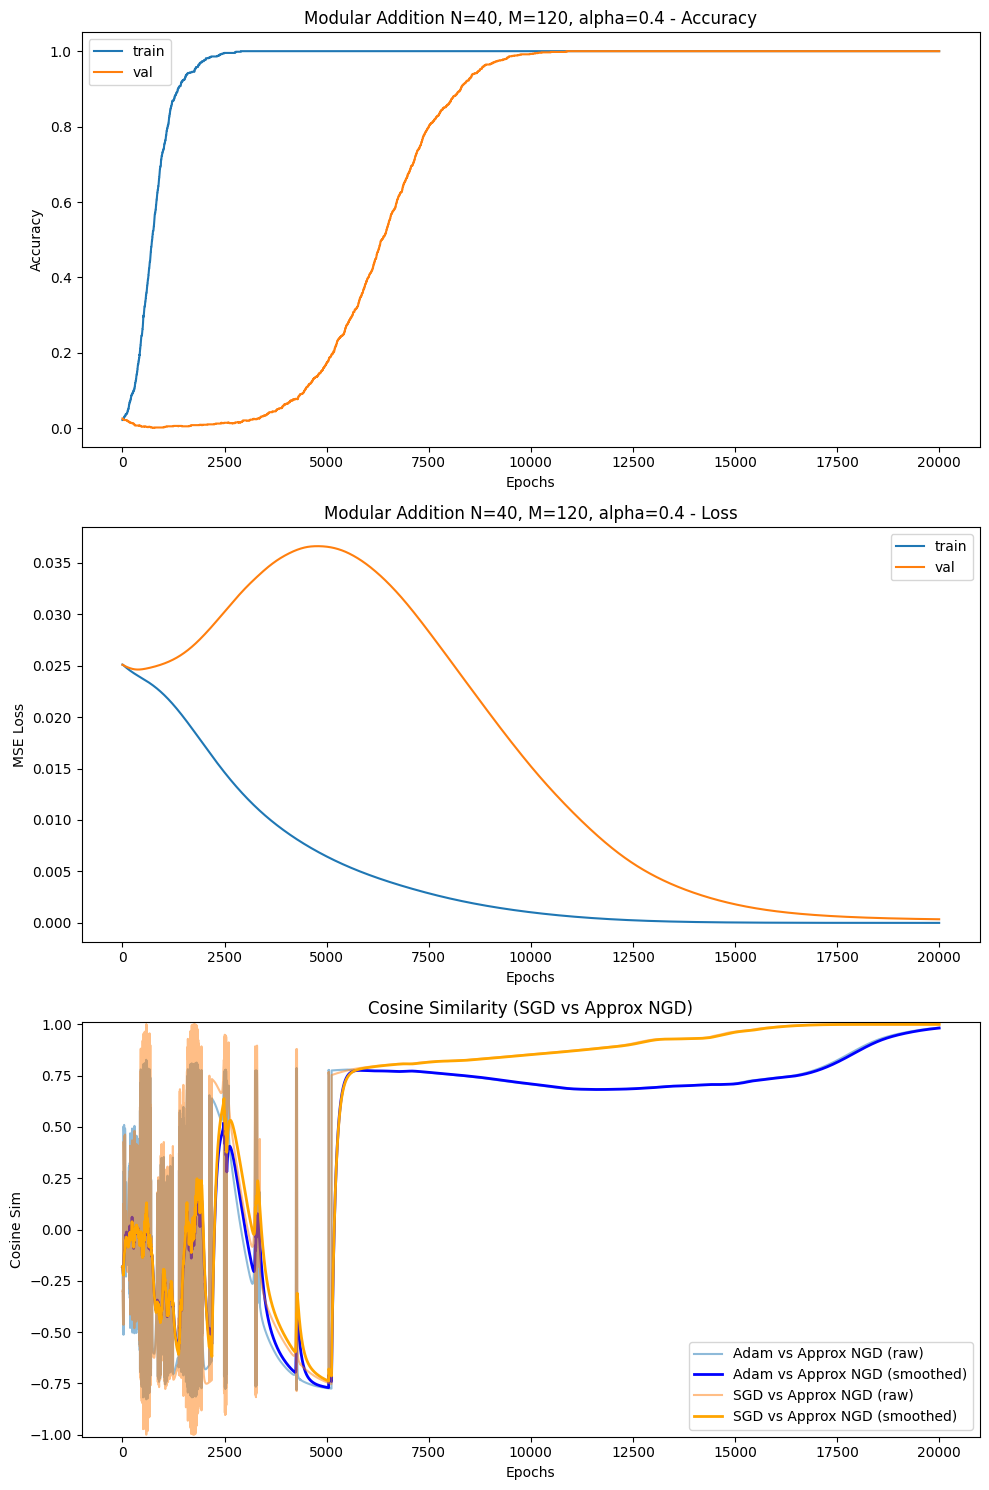

Metrics saved to metrics_groknet.pkl


In [19]:
if __name__ == "__main__":
    assert torch.cuda.is_available(), "Please turn on GPU accelerator. On Google Colab, it is Runtime -> Change runtime type -> GPU"
    run_training(N=40, M=120, alpha=0.4, budget=20000, batch_size=512, lr=1e-3)

Using device: cuda


Training: 100%|██████████████| 20000/20000 [07:49<00:00, 42.58it/s, train acc=1.0000, val acc=1.0000, CS_Adam_NG=0.9794]


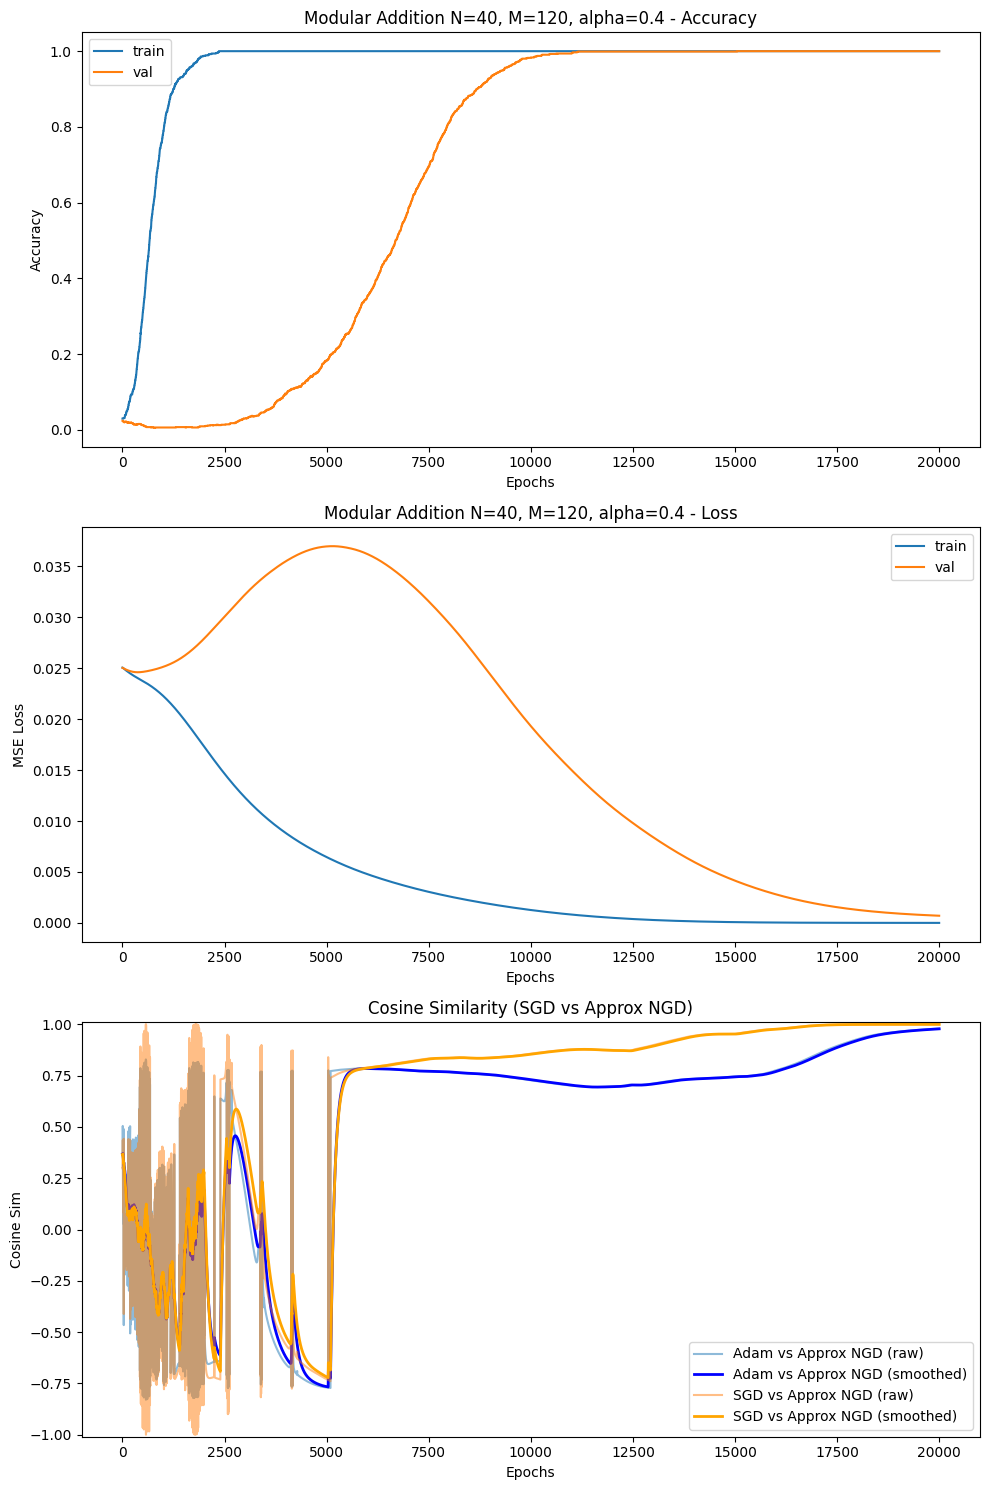

Metrics saved to metrics_groknet.pkl


In [3]:
run_training(N=40, M=120, alpha=0.4, budget=20000, batch_size=512, lr=1e-3, seed = 1010)

Using device: cuda


Training: 100%|██████████████| 20000/20000 [07:46<00:00, 42.83it/s, train acc=1.0000, val acc=0.0208, CS_Adam_NG=0.9728]


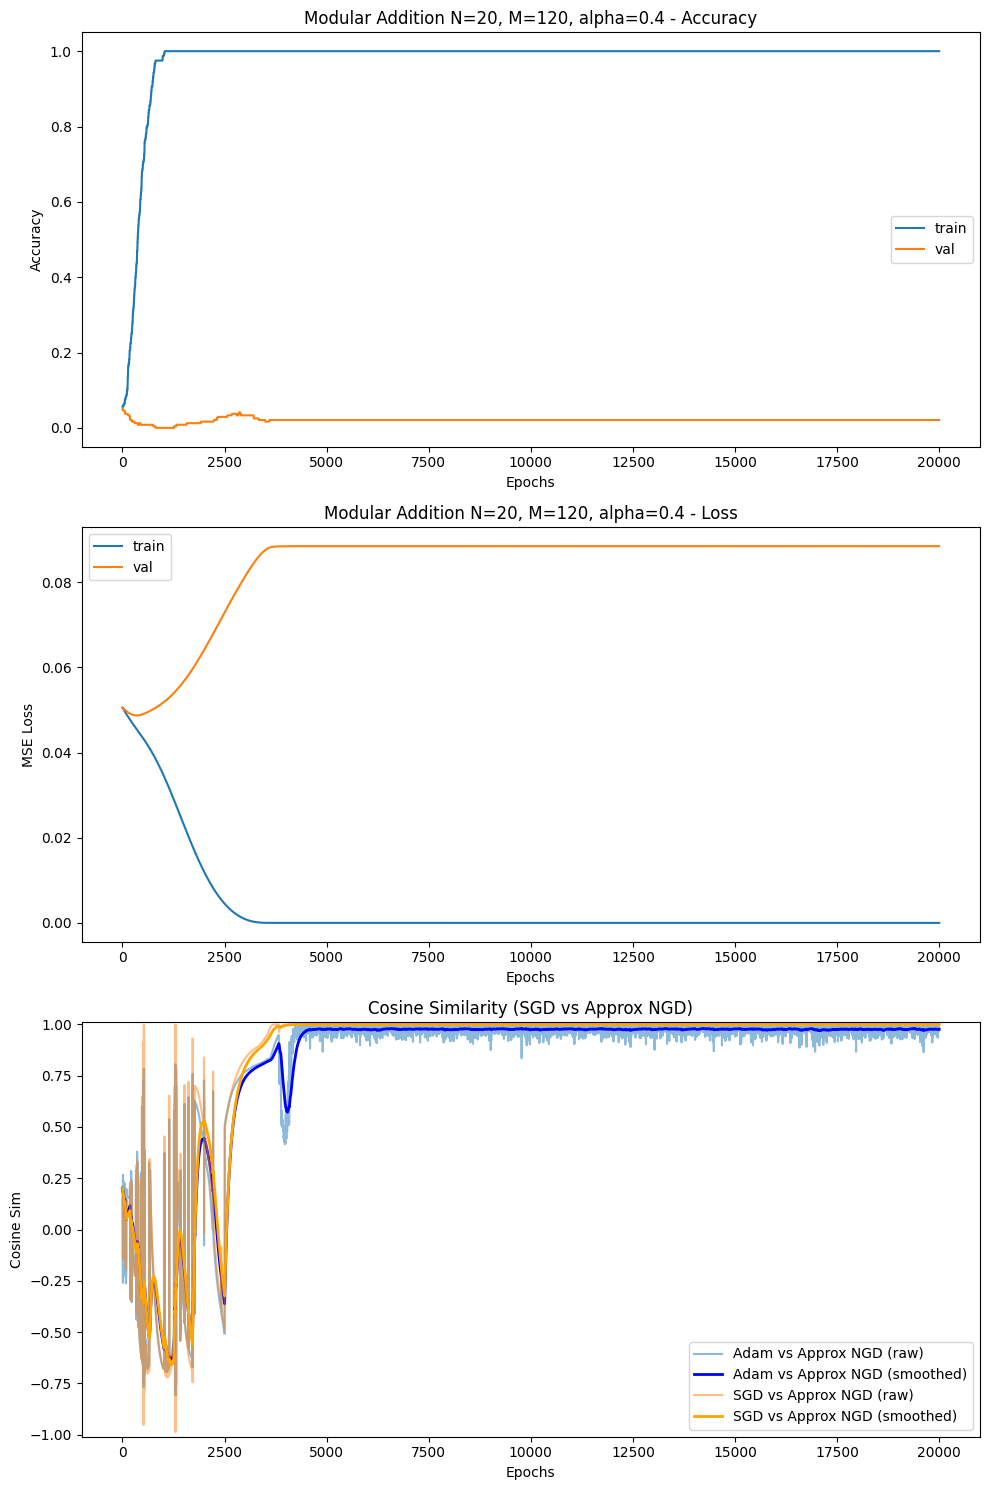

Metrics saved to metrics_groknet.pkl


In [4]:
run_training(N=20, M=120, alpha=0.4, budget=20000, batch_size=512, lr=1e-3, seed = 1111)

Using device: cuda


Training: 100%|██████████████| 20000/20000 [08:19<00:00, 40.07it/s, train acc=1.0000, val acc=1.0000, CS_Adam_NG=0.6452]


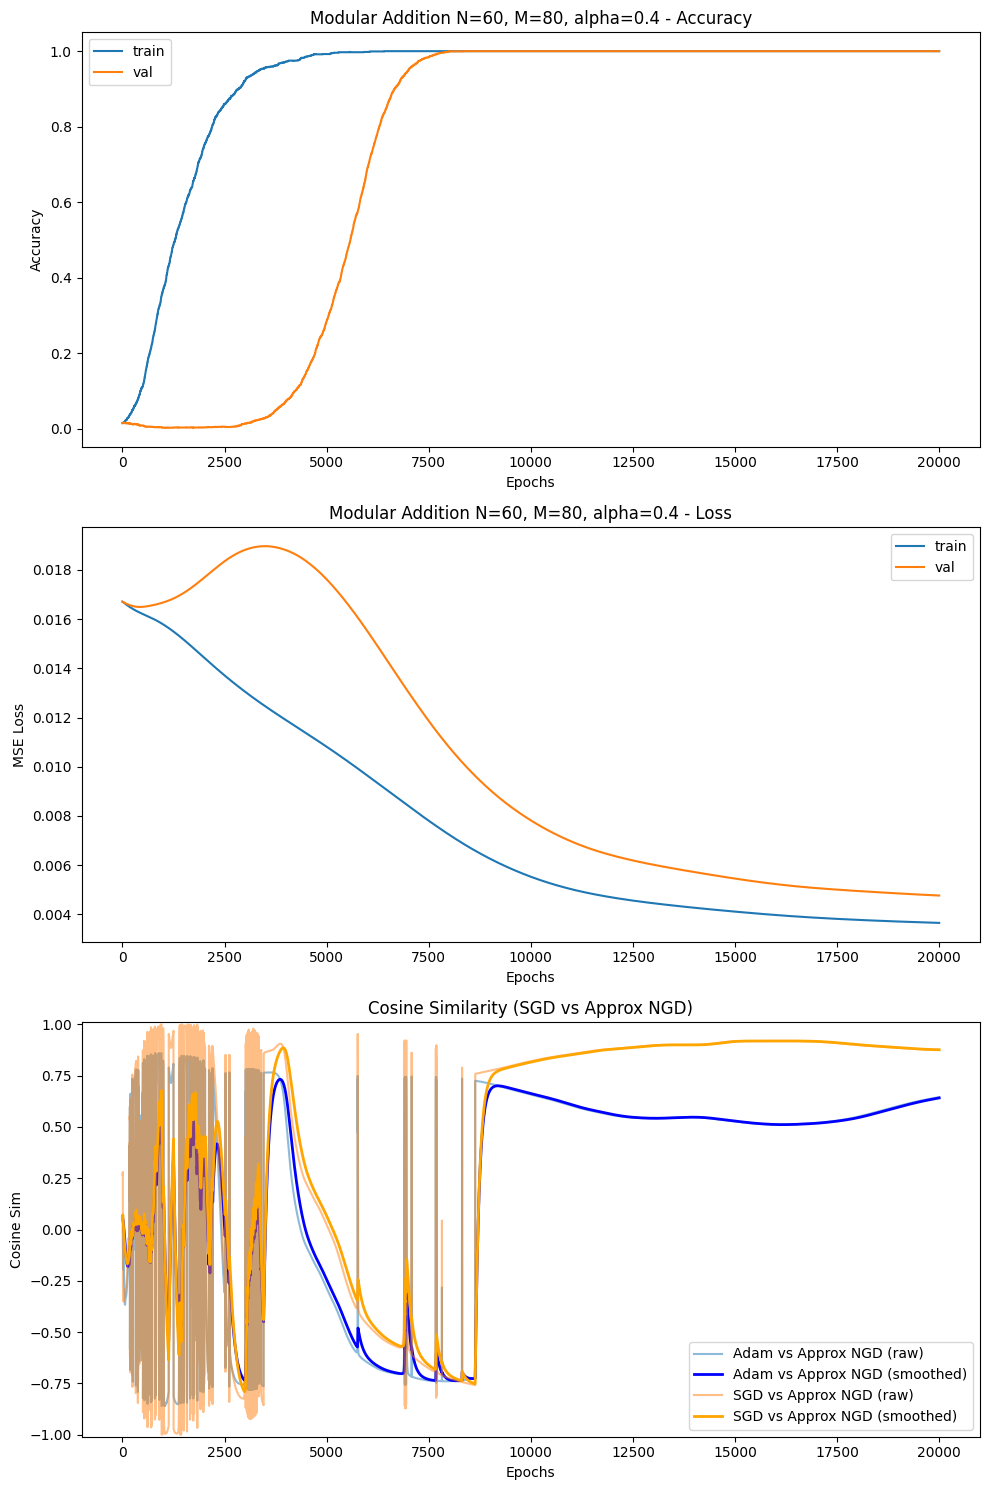

Metrics saved to metrics_groknet.pkl


In [5]:
run_training(N=60, M=80, alpha=0.4, budget=20000, batch_size=512, lr=1e-3, seed = 1111)

Using device: cuda


Training: 100%|██████████████| 20000/20000 [07:14<00:00, 46.04it/s, train acc=1.0000, val acc=1.0000, CS_Adam_NG=0.9658]


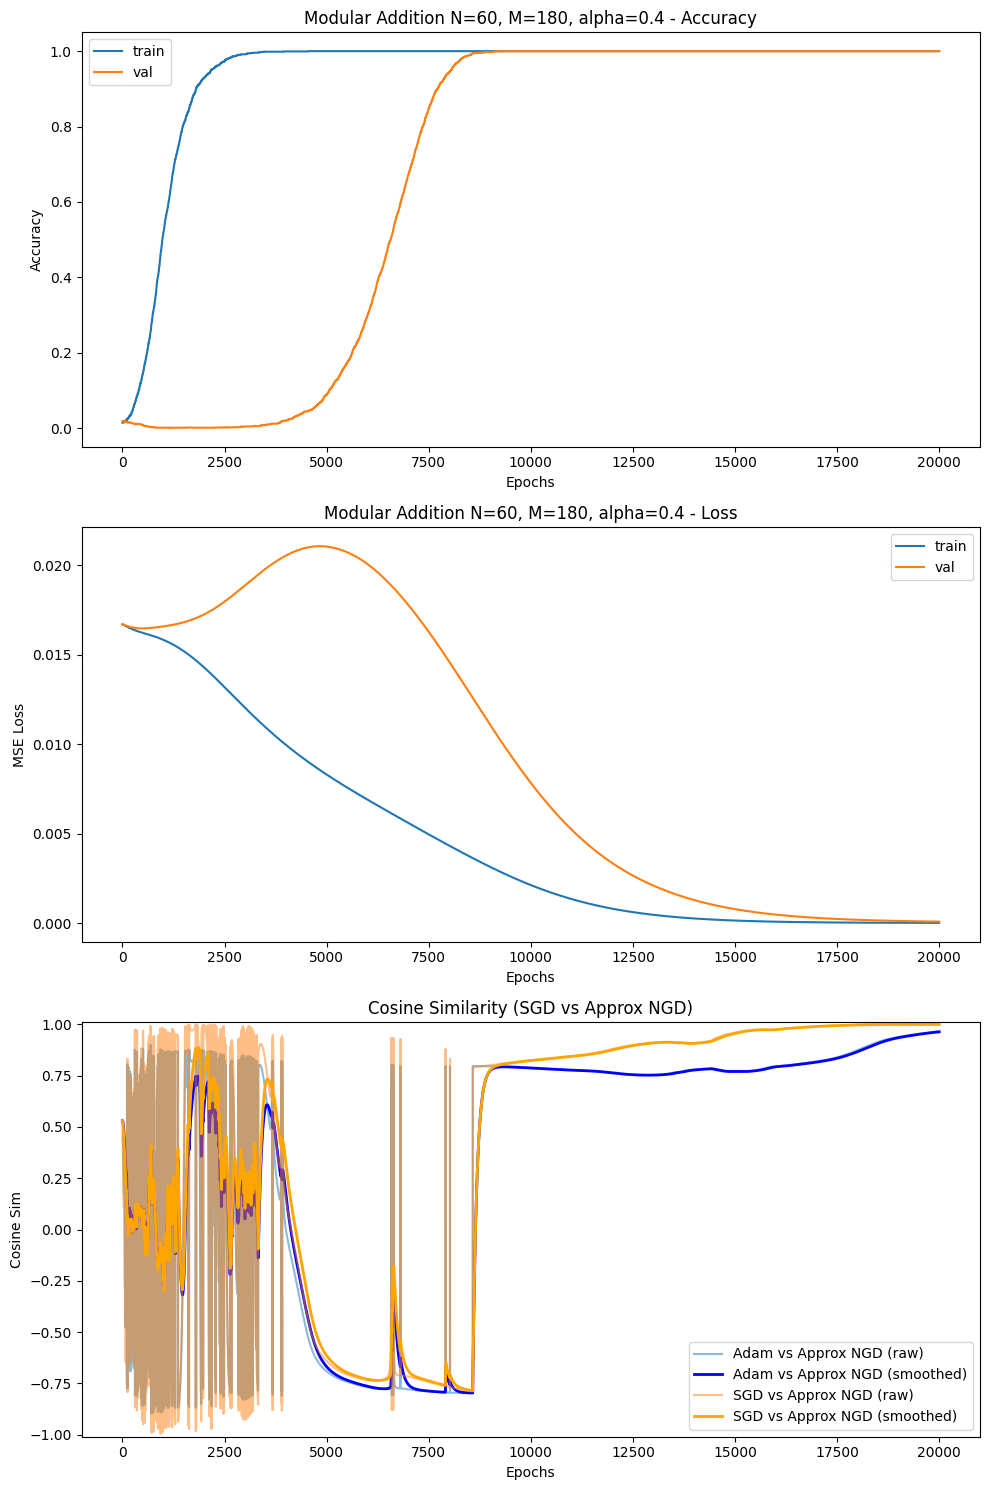

Metrics saved to metrics_groknet.pkl


In [6]:
run_training(N=60, M=180, alpha=0.4, budget=20000, batch_size=512, lr=1e-3, seed = 1111)